# Investigating age in the player.csv dataset to predict playing hours 
## Introduction
### Background Information & the question:
A research group led by Frank Wood at UBC is collecting data and using it to understand how people play video games, in particular Minecraft. Wood and his team have three broad questions they would like to address:

Question 1: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

Question 2: What "kinds" of players are most likely to contribute to a large amount of data?

Question 3: What time windows are most likely to have large numbers of simultaneous players.

Wood and his team collected two datasets, `players.csv` and `sessions.csv`.

In this project, using the data sets collected from Wood and his team, we will attempt to answer the question:

"Can the **age** of a player help predict the **playing time** of users in the `players.csv` dataset?"
### The Dataset:
In the `players.csv` dataset there are 196 observations and 7 different variables.

- `experience`: Indicates the category of skill level

- `subscribe`: Indicates whether a player is subscribed (TRUE) or not (FALSE), a logical value

- `hashed_email`: Indicates the players unique email, character data

- `played_hours`: Indicates number of hours spent playing, a numeric value

- `name`: Indicates the players name, character data

- `gender`: Indicates the players gender identity, a categorical value

- `age`: Indicates the players age in years, a numeric value

There are a few issues with the dataset including:
1. The option for players to report "prefer not to say" for gender. This could cause issues when using gender as a predictive variable as it introduces uncertainty and missing data,
2. NA (missing data) values throughout the columns, this could lead to less accurate predictions
3. Disproportionate hours played between experience levels

Issues regarding the disproportionate hours played could be due to players with greater experience finding less enjoyment in playing the game and thus playing it less during the observational period. The large age range of study participants could also affect the data collected depending on what time of the year the observations took place (e.g. high-school aged participants and older may have other commitments from September-June which could affect their playing hours). The data was likely collected from sign-up information alongside tracking data for `played_hours`.

## Methods and Results

### 1. Preprocessing and exploratory data analysis

#### Importing the necessary libraries

In [88]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)

#### Importing the dataset 

In [89]:
player_data <- read_csv("https://raw.githubusercontent.com/bellamartens/Individual_Project/refs/heads/main/players.csv")

player_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17


*figure 1*: players.csv dataset

#### Wrangling the data

As we can see above, the column names **hashedEmail** and **Age** are not properly named and need to be changed to follow the format of the other titles. Furthermore, any rows containing "NA" in the `age` column of the dataset were removed, as a regression model would not be able to predict `played_hours` values for those rows. 

In [90]:
player_data <- rename(player_data,
                      hashed_email = hashedEmail,
                      age = Age) |>
               filter(age != "NA")

player_data

experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,644fe4200c19a73768b3fa598afcbd0948f7557925b7f17166285da23af31cc6,0.0,Rhys,Male,20
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22


*figure 2*: Tidied dataset

#### Splitting the data into training and testing sets

We use `initial_split` to randomly divide our data into training and testing sets, which helps prevent bias and ensures our model is evaluated on unseen data. 

This split allows us to train the model effectively while keeping a separate portion for assessing its performance.

75% and 25% is a standard split for this type of analysis. 

Now we will work with training data for exploratory data analysis.

In [91]:
set.seed(3000)
player_split <- initial_split(player_data, prop = 0.75, strata = played_hours)
player_training <- training(player_split)
player_testing <- testing(player_split)

#### Summary statistics for the training data

Using `group_by` and `summarize` functions, data analysis will be performed to better understand trends and relationships in the data set.

The mean, median and standard deviation for the age will be calculated to check for unusual age ranges.

The mean, median and standard deviation for the playing hours will be calculated to check for outliers.

In [92]:
played_hours_stats <- player_training |>
             summarize(mean_played_hours = mean(played_hours, na.rm = TRUE),
                       median_played_hours = median(played_hours, na.rm = TRUE),
                       sd_played_hours = sd(played_hours, na.rm = TRUE))
                        
                                            
age_stats <- player_training |>
                summarize(mean_age = mean(age, na.rm = TRUE),
                          median_age = median(age, na.rm = TRUE),
                          sd_age = sd(age, na.rm = TRUE))
                                            
                          
played_hours_stats
age_stats

mean_played_hours,median_played_hours,sd_played_hours
<dbl>,<dbl>,<dbl>
5.977931,0.1,27.34447


mean_age,median_age,sd_age
<dbl>,<dbl>,<dbl>
20.55172,18,6.423623


*figure 3*: Summary statistics for `age` and `played_hours`

Reported  playing hours ranged from 0 to 218.1 hours (mean: 4.5, SD: 20.7), with a few high values indicating potential outliers. Many players reported playing no hours which  limits the model’s ability to accurately learn patterns between age and playing hours. 

The dataset contains 196 participants aged between 8 and 42 (mean age: 20, SD: 5.7). 

#### Data Visualization

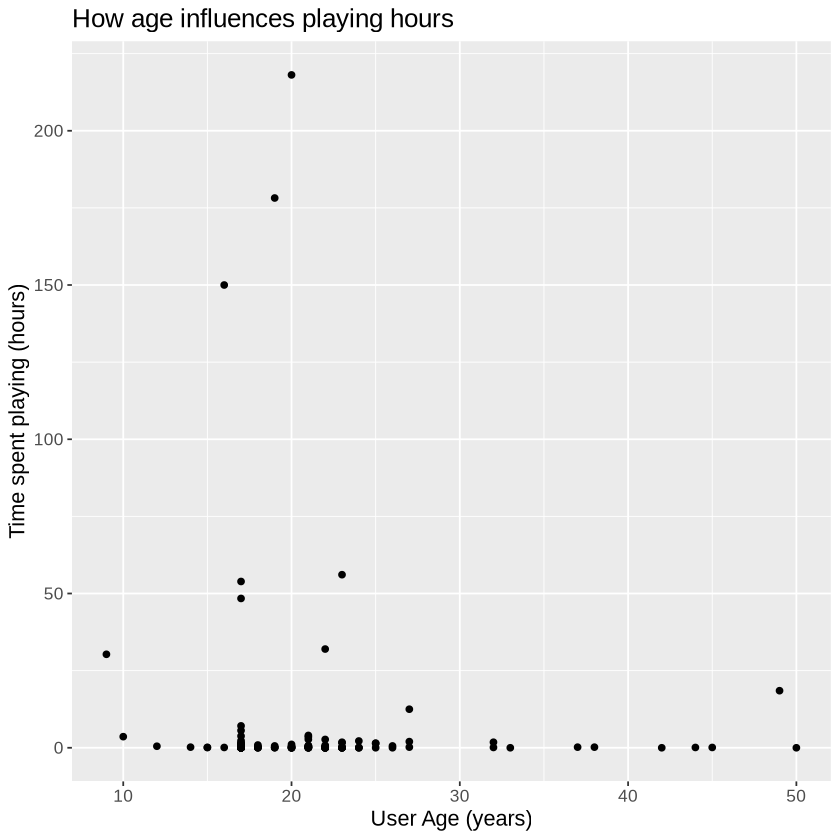

In [93]:
options(repr.plot.width = 7, repr.plot.height = 7) 

plot_1 <- player_training |> 
          ggplot(aes(x = age, y = played_hours)) +
          geom_point () +
          labs(x = "User Age (years)", y = "Time spent playing (hours)") +
          ggtitle("How age influences playing hours") +
 theme(text = element_text(size = 13))

plot_1

*figure 4*: Scatterplot of hours played vs. user age

This scatter plot very loosely shows that ages ranging between 16-22 may have higher playing hours. These are the only ages where there are outliers with very high playing hours (150hrs+). However much of the data doesn't report playing hours for many of the ages, meaning the relationship is unable to be confirmed.  

### 2. Data Analysis

Create a specification for this model that indicates we are performing a K nearest-neighbors regression analysis on the data. A regression model is the best option for this type of data analysis as the predicted value is a quantitative variable.

In [94]:
# setting up the kknn model
set.seed(3000)
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

Preprocess the data for Knn regression by creating a recipe. In this case we are using "age" as the sole predictor. Then use `step_scale()` and `step_center()` on the predictors to ensure no one predictor is having a more significant effect on the outcomes. 

In [95]:
# setting up the recipe
set.seed(3000)
player_recipe <- recipe(played_hours ~ age, data = player_training) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

**Creating splits in the training data for a 5 fold cross validation.** 

This means we are splitting the data into 5 parts and conducting the analysis 5 times, each using 4 parts for training and 1 part for validation.

A 5 fold cross validation is standard for this analysis.

Create a workflow that combines the previous model specifications and the recipe created. 

In [96]:
# creating the vfold and workflow to begin looking for the best k value to use
set.seed(3000)
player_vfold <- vfold_cv(player_training, v = 5, strata = played_hours)

player_workflow <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(player_spec)

We will then run the cross validation using grid numbers 1 to 100 by intervals of 5.

We then tune the grid created to test all the values for K and collect metrics to find out some more information on the different possible K values.

A vizualization can then be made off these results to show the accuracy of K-values in graph format.

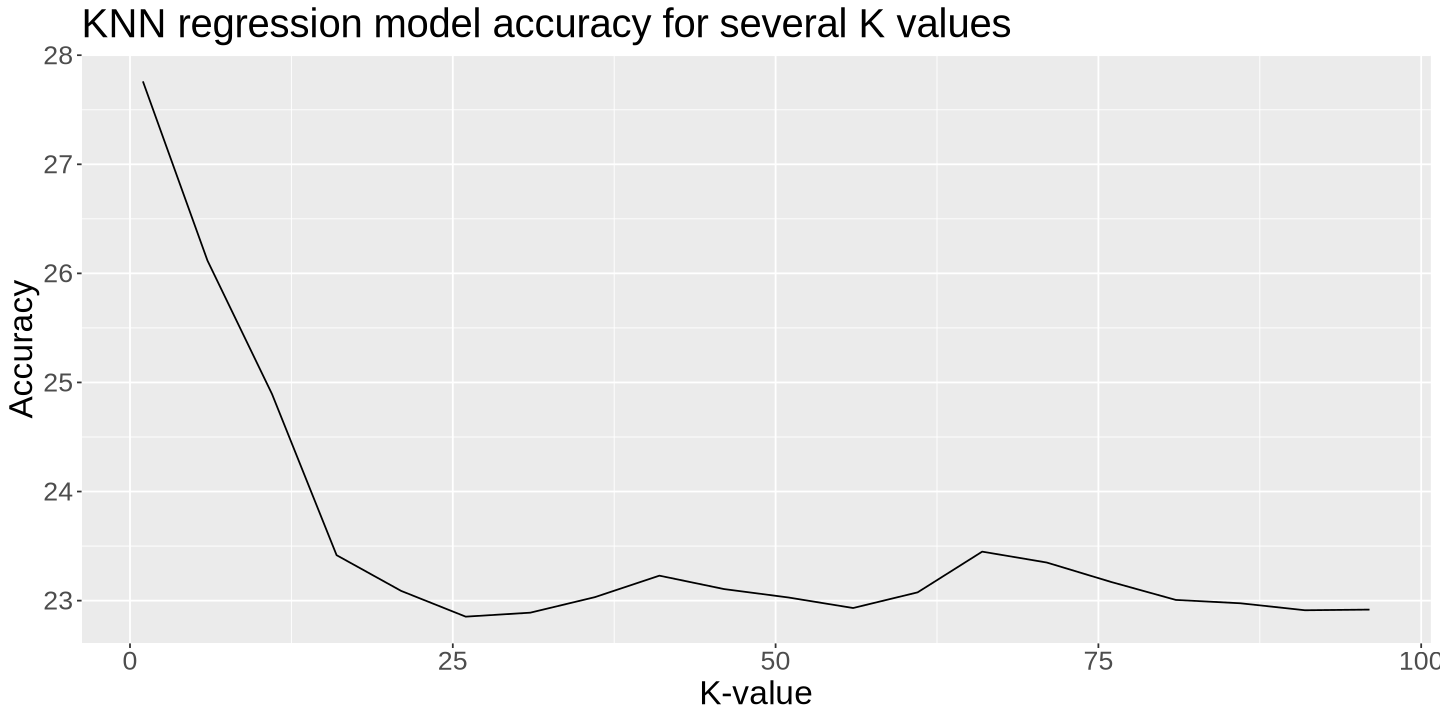

In [97]:
# getting the metrics to see which k values have the best rmse
set.seed(3000)
gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

player_results <- player_workflow |>
  tune_grid(resamples = player_vfold, grid = gridvals) |>
  collect_metrics()

options(repr.plot.height = 6, repr.plot.width = 12)

player_results_graph <- player_results |> filter(.metric == "rmse") |>
                        ggplot(aes(x = neighbors, y = mean)) +
                                geom_line() +
                                labs(x = "K-value",
                                     y = "Accuracy",
                                     title = "KNN regression model accuracy for several K values") +
                                theme(text = element_text(size = 20))

player_results_graph

*figure 5*: Graph of Accuracy vs. K-value

**To find the best K value using the RMSPE,** we take the previous workflow and produce metrics and filter by `rmse`, then use the `slice_min()` function to highlight the K value with the lowest RMSPE. Finding the minimum RMSPE and its metrics to find which number of neighbors “K” gives the lowest standard error.

In [98]:
# filtering for the best k value
set.seed(3000)
player_min <- player_results |>
   filter(.metric == 'rmse') |>
   slice_min(mean)

player_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
26,rmse,standard,22.85297,5,7.749875,Preprocessor1_Model06


*figure 6*: Best K value (26)

#### Knn Regression

We then extract that K value using the `pull()` function to create a new value `k_min` that will return the best K value when used in the next analysis. 

The nearest neighbor function is used again but this time we set the neighbors argument equal to the `k_min` value. Same as before we will use set_engine to specify the kknn engine and use `set_mode()` to specify we are performing a regression analysis.

A workflow is then created to combine the initial recipe with the new nearest neighbor specification and is fitted to the training data.

In [99]:
# using the best k value to make the best model and workflow
set.seed(3000)
k_min <- player_min |>
         pull(neighbors)

player_best_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = k_min) |>
         set_engine('kknn') |>
         set_mode('regression')

player_best_fit <- workflow() |>
         add_recipe(player_recipe) |>
         add_model(player_best_spec) |>
         fit(data = player_training)

We can then create a summary using the our best fit model on the testing data to see how accurate the model is.

The larger the `.estimate` value is for the `rmse`, the worse the model is at fitting out data.

In [100]:
# getting the summary results of the best model to use for prediction and vizualization
set.seed(3000)
player_summary <- player_best_fit |>
          predict(player_testing) |>
          bind_cols(player_testing) |>
          metrics(truth = played_hours, estimate = .pred) |>
          filter(.metric == "rmse")

player_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,32.74736


*figure 7*: `rmse` of the best model

Creating a plot to visualize our regression model against the data.

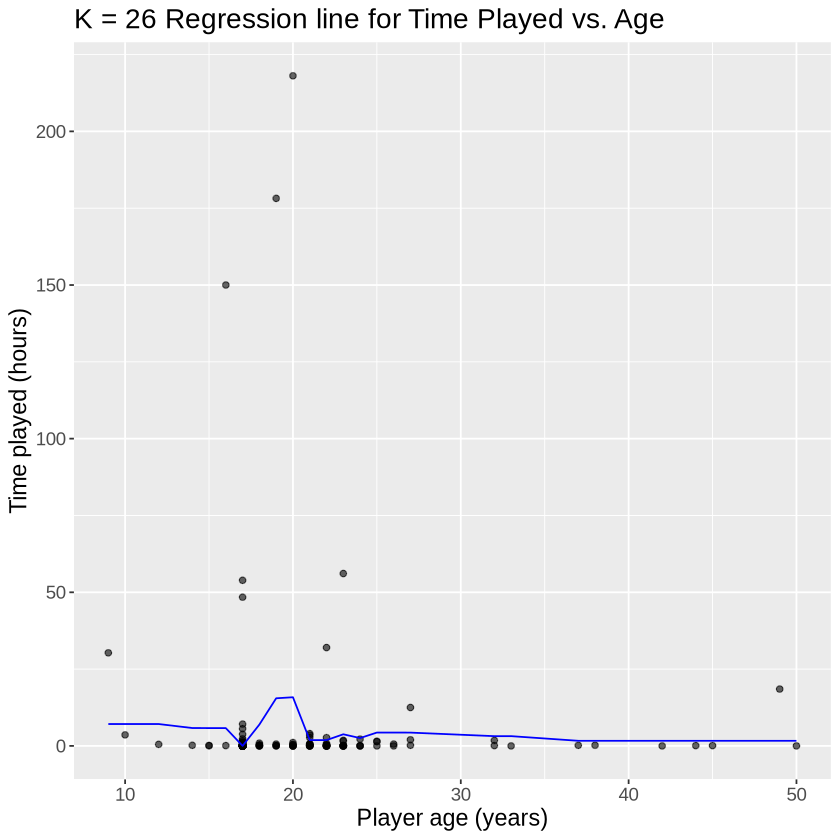

In [101]:
# creating the vizualization of the best k value regression line
set.seed(3000)
options(repr.plot.width = 7, repr.plot.height = 7)

player_preds <- player_best_fit |>
  predict(player_training) |>
  bind_cols(player_training)

player_plot <- ggplot(player_preds, aes(x = age, y = played_hours)) +
  geom_point(alpha = 0.6) +
  geom_line(data = player_preds,
            mapping = aes(x = age, y = .pred),
            color = "blue") +
              xlab("Player age (years)") +
              ylab("Time played (hours)") +
                ggtitle('K = 26 Regression line for Time Played vs. Age') +
            theme(text = element_text(size = 14))

player_plot

*figure 8*: vizualization of regression model predictions against the data

## Discussion

### Summarize what you found.

The model does not represent the data very well. Our analysis conclcuded that the best K value for this knn regression analysis was 26. However when we calculated the RMSPE for this model we found that the rmse error was ~33. A large number in this case means that our model was not very accurate and for any age selected the model would be able to predict the players playing hours within 33 hours. 33 hours is large relative to the typical number of hours played and is not an accurate prediction.

### Discuss whether this is what you expected to find?

This was expected because as the exploratory data analysis showed large outliers in the `played_hours` variable, alongside a large number of users that have played for zero hours. These outliers are not representative of the general population's playing habits, and the large number of zero value makes it hard to predict `played_hours` with any of the variables in the dataset including `age`.

It could also be that `age` has no relation to `played_hours` regardless of issues in the dataset. This is also expected as it is hard to develop reasoning for why a certain age would play the game more than others, considering most users barely played at all.

The dataset was also relatively small and therefore may not offer enough data to investigate whether there is a correlation between age and playing hours.

### Discuss what impact could such findings have?

If the data did show a strong correlation between players age and their play time this information could be used for improvement and specialization of the game. 

If we were able to find out people's age based on their playing hours, and for example we found that the most hours were played by users aged 19-25 the content could be better tailored to that age group, improving the experience for the people playing the most.

The advertising to the game could also be tailored more to the demographic of people that would play the longest, ensuring that money spent on marketing is efficiently used.

### Discuss what future questions could this lead to?
If we found that age is not able to accurately predict the playing time of users on this game, the next logical question to ask would be what is accurately able to predict the hours played.

We could test some of the other variables like gender, experience or subscription to see if any of them have a closer relationship to hours played. Maybe none of them do on their own and we would need a combination of variables to yield a more accurate prediction. 

Another question that could be proposed is how to alter the data collection process to make future data analysis easier. As stated earlier, there are problems in the dataset, notably the large number of players who have played for zero hours. If data collection was adjusted to address this issus, models performing data analysis would produce better results and predictions.
